# TAOS mars3D: tides

- load time series 
- compute tidal analysis
- make prediction and compare
- compute envelopes of semi-diurnal/diurnal tides
- compute harmonic analysis over entire domain

[pytide conventions](https://pangeo-pytide.readthedocs.io/en/latest/pytide.html#pytide.WaveTable.harmonic_analysis)



In [2]:
import os
from glob import glob
from tqdm import tqdm

import numpy as np
import xarray as xr
import pandas as pd

import dask
from dask import delayed

from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline

import pytide

import taos.utils as ut
import taos.mars as ms

In [3]:
if False:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    #cluster = PBSCluster(processes=4, cores=4) # std
    w = cluster.scale(jobs=5)
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 56,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56216,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 56
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:34774,Total threads: 7
Dashboard: http://127.0.0.1:36419/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:53534,


---

## load station data

**The processing over the full dataset is now done non interactively, see station.pbs and station.py**


In [69]:
station_files = sorted(glob(os.path.join(ms.diag_dir, "station_20*.nc")))
ds_all = [xr.open_dataset(f) for f in station_files]
ds = xr.concat(ds_all, dim="time").persist()

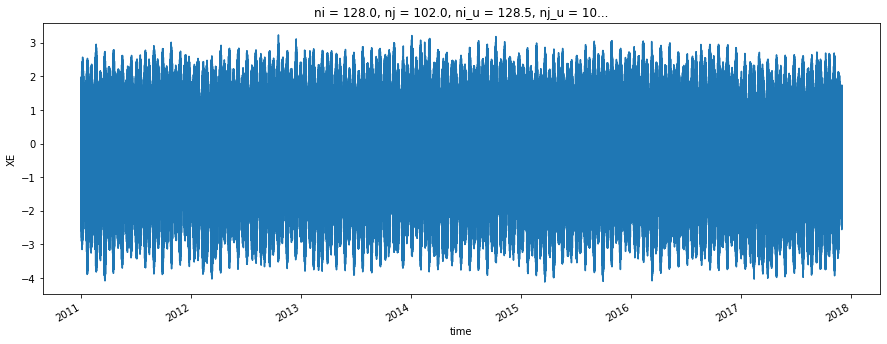

In [70]:
ds.XE.plot(figsize=(15,5))

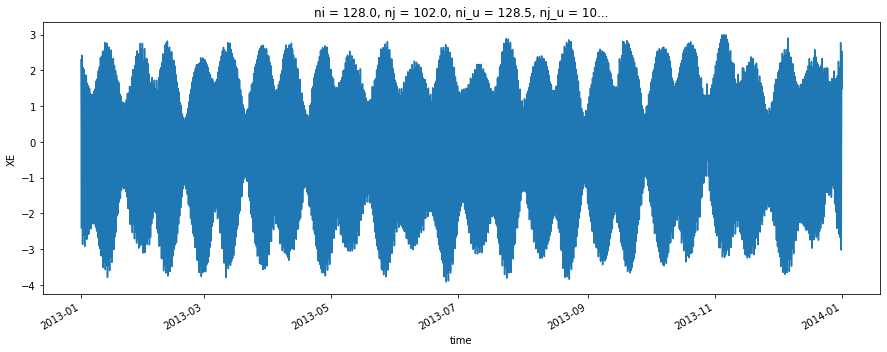

In [71]:
#for y in np.unique(ds.time.dt.year.data):
_ds = ds.where(ds.time.dt.year==2013, drop=True)
_ds.XE.plot(figsize=(15,5))

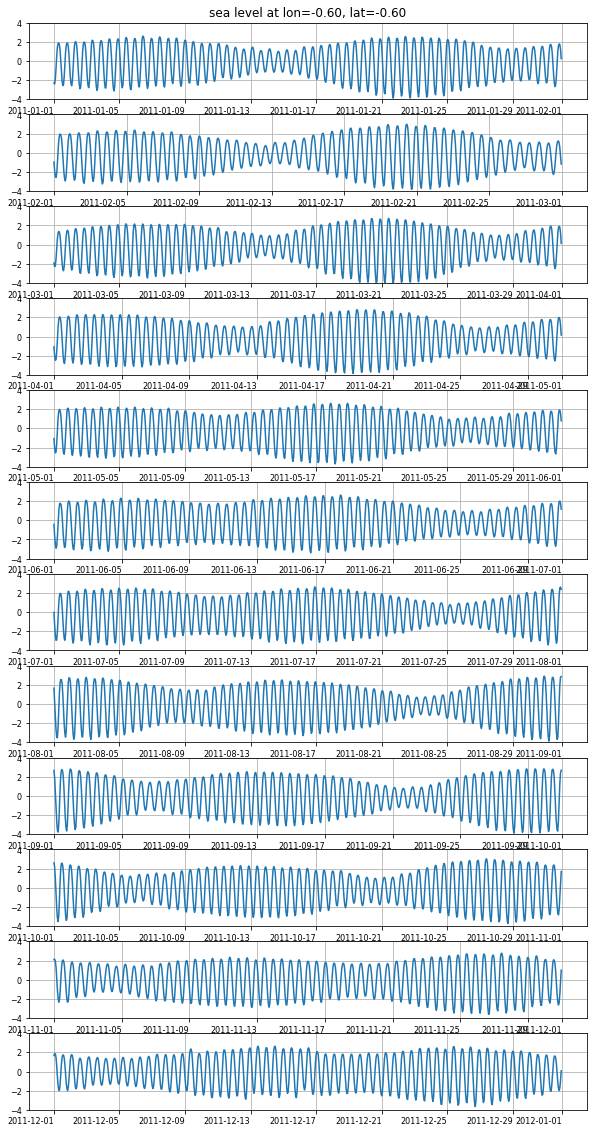

In [72]:
years = np.unique(ds.time.dt.year.values)
lon = float(ds.longitude)
lat = float(ds.longitude)

for year in years:
    _ds = ds.sel(time=str(year))

    fig, axes = plt.subplots(12,1, figsize=(10,20))

    i=0
    for label, g in _ds.time.to_dataframe()["time"].groupby(pd.Grouper(freq="1M")):
        ax = axes.flatten()[i]
        _ds.sel(time=slice(g.iloc[0], g.iloc[-1])).XE.plot(ax=ax)
        if i==0:
            ax.set_title("sea level at lon={:.2f}, lat={:.2f}".format(lon, lat))
        else:
            ax.set_title("")
        ax.set_ylim(-4,4)
        ax.grid()
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.tick_params(axis='both', which='major', labelsize=8, rotation=0, )
        ax.tick_params(axis='both', which='minor', labelsize=8, rotation=0)
        i+=1
    fig.subplots_adjust(hspace=.2)
    #fig.savefig("tide_{}.jpg".format(year))
    if year>years[0]:
        plt.close(fig)

--- 
### tidal analysis

In [73]:
#def get_tidal_harmonics(time, eta):

wt = pytide.WaveTable() # not working on months like time series, need to restrict
# to restrict the constituents used
#wt = pytide.WaveTable(["M2", "S2", "N2", "K2", "K1", "O1", "P1", "Q1", "S1", "M4"]) 

time = ds.time.values.astype("datetime64[us]")
f, vu = wt.compute_nodal_modulations(time)

# perform the harmonic analysis
w = wt.harmonic_analysis(ds.XE.values, f, vu)

# put harmonic analysis results in dataset
dsh = xr.Dataset(dict(frequency=("constituent", wt.freq()*86400/2/np.pi),
                      frequency_rad=("constituent", wt.freq()), 
                      amplitude=("constituent", w),
                     ),
                 coords=dict(constituent=("constituent", wt.constituents()))
                )

# store for later use
if False:
    # netcdf does not not 
    dsh["amplitude_real"] = np.real(dsh["amplitude"])
    dsh["amplitude_imag"] = np.imag(dsh["amplitude"])
    dsh = dsh.drop_vars("amplitude")
    dsh.to_netcdf(os.path.join(ms.diag_dir,"station_tide.nc"), mode="w")

In [74]:
dsp = ut.predict_tides(ds.time, real=False, summed=False)
tidal_range = ut.compute_tidal_range(dsp.prediction)

Text(0.5, 1.0, 'Tidal harmonic amplitudes')

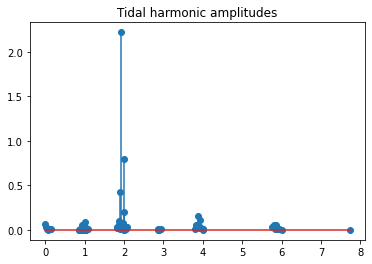

In [75]:
fig, ax = plt.subplots(1,1)
ax.stem(dsp.frequency, abs(dsp.amplitude))
ax.set_title("Tidal harmonic amplitudes")
#ax.xlim()

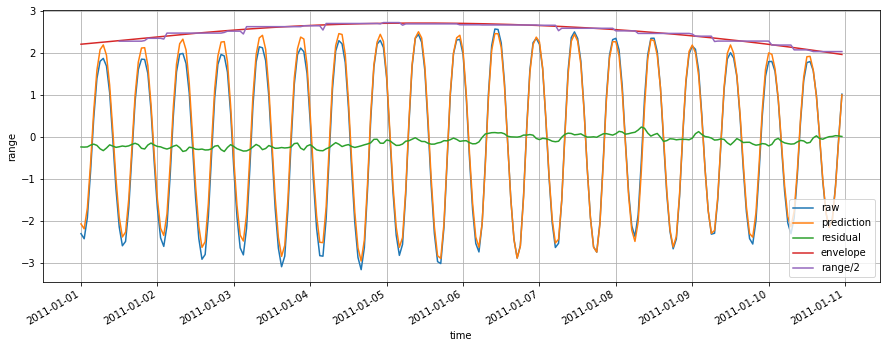

In [93]:
fig, ax = plt.subplots(1,1, figsize=(15,5))

#t_slice = slice(0,24*20)
t_slice = slice(0,24*10)
_ds = ds.isel(time=t_slice)
_dsp = dsp.isel(time=t_slice)

_ds.XE.plot(ax=ax, label="raw")
_dsp.prediction.plot(ax=ax, label="prediction")
#_dsp.prediction_quad.plot(ax=ax, label="prediction, imag")
#envelope = abs(_ds.XE_harmonic+1j*_ds.XE_harmonic_quad)
#envelope.plot(ax=ax)

(_ds.XE - _dsp.prediction).plot(label="residual")

_dsp = _dsp.where( (_dsp.frequency>1.5) & (_dsp.frequency<2.5) )
#_ds = _ds.where( _ds.frequency>0.5 )
np.abs(_dsp["complex"].sum("constituent")).plot.line(label="envelope")

_trange = tidal_range.isel(time=t_slice)
(_trange/2).plot(ax=ax, label="range/2")

ax.grid()
ax.legend()


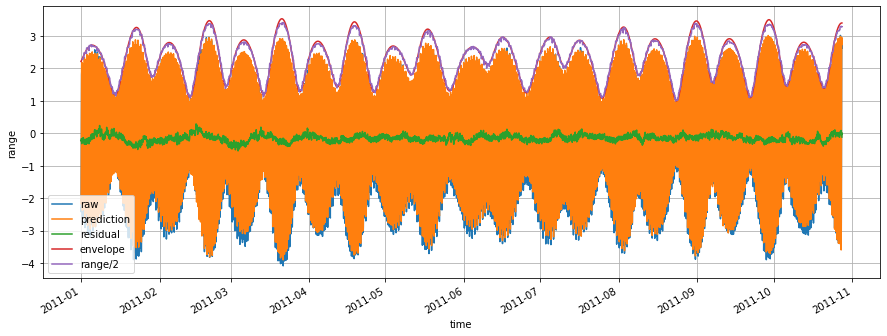

In [94]:

fig, ax = plt.subplots(1,1, figsize=(15,5))

t_slice = slice(0,24*300)
_ds = ds.isel(time=t_slice)
_dsp = dsp.isel(time=t_slice)

_ds.XE.plot(ax=ax, label="raw")
_dsp.prediction.plot(ax=ax, label="prediction")
#_dsp.imag_summed.plot(ax=ax)
#envelope = abs(_ds.XE_harmonic+1j*_ds.XE_harmonic_quad)
#envelope.plot(ax=ax)

(_ds.XE - _dsp.prediction).plot(label="residual")

_dsp = _dsp.where( (_dsp.frequency>1.5) & (_dsp.frequency<2.5) )
#_ds = _ds.where( _ds.frequency>0.5 )
np.abs(_dsp["complex"].sum("constituent")).plot.line(label="envelope")

_trange = tidal_range.isel(time=t_slice)
(_trange/2).plot(ax=ax, label="range/2")

ax.grid()
ax.legend()

---

## analyze currents, sea level in 2D

In [4]:
ds2D = xr.open_zarr(os.path.join(ms.diag_dir, "fields_2d.zarr"))
ds2D

<xarray.Dataset>
Dimensions:      (time: 79103, nj: 183, ni: 413, ni_u: 413, nj_v: 183)
Coordinates:
    latitude     (nj, ni) float64 dask.array<chunksize=(183, 413), meta=np.ndarray>
    latitude_u   (nj, ni_u) float64 dask.array<chunksize=(183, 413), meta=np.ndarray>
    latitude_v   (nj_v, ni) float64 dask.array<chunksize=(183, 413), meta=np.ndarray>
    level        float32 ...
    longitude    (nj, ni) float64 dask.array<chunksize=(183, 413), meta=np.ndarray>
    longitude_u  (nj, ni_u) float64 dask.array<chunksize=(183, 413), meta=np.ndarray>
    longitude_v  (nj_v, ni) float64 dask.array<chunksize=(183, 413), meta=np.ndarray>
  * ni           (ni) float32 0.0 1.0 2.0 3.0 4.0 ... 409.0 410.0 411.0 412.0
  * ni_u         (ni_u) float32 0.5 1.5 2.5 3.5 4.5 ... 409.5 410.5 411.5 412.5
  * nj           (nj) float32 0.0 1.0 2.0 3.0 4.0 ... 179.0 180.0 181.0 182.0
  * nj_v         (nj_v) float32 0.5 1.5 2.5 3.5 4.5 ... 179.5 180.5 181.5 182.5
  * time         (time) datetime64[ns] 2010-01-01T01:00:00 ... 2019-01-01
Data variables:
    SAL_surf     (time, nj, ni) float32 dask.array<chunksize=(48, 183, 413), meta=np.ndarray>
    TEMP_surf    (time, nj, ni) float32 dask.array<chunksize=(48, 183, 413), meta=np.ndarray>
    U            (time, nj, ni_u) float32 dask.array<chunksize=(48, 183, 413), meta=np.ndarray>
    UZ_surf      (time, nj, ni_u) float32 dask.array<chunksize=(48, 183, 413), meta=np.ndarray>
    V            (time, nj_v, ni) float32 dask.array<chunksize=(48, 183, 413), meta=np.ndarray>
    VZ_surf      (time, nj_v, ni) float32 dask.array<chunksize=(48, 183, 413), meta=np.ndarray>
    XE           (time, nj, ni) float32 dask.array<chunksize=(48, 183, 413), meta=np.ndarray>
    phi          (time, nj, ni) float64 dask.array<chunksize=(48, 183, 413), meta=np.ndarray>
    sigma0_surf  (time, nj, ni) float64 dask.array<chunksize=(48, 183, 413), meta=np.ndarray>
Attributes: (12/55)
    Conventions:             CF-1.6 OCO-1.3.1 COMODO-1.0
    arakawa_grid_type:       C1
    area:                    SEINE
    comment:                 Use of Meteo-France AROME meteorological data
    contact:                 cdoco-exploit@ifremer.fr
    creation_date:           2019-08-17T19:43:27Z
    ...                      ...
    source:                  MARS MANGAE2500-AGRIF
    southernmost_latitude:   49.2424
    start_date:              2018-12-29T00:00:00Z
    stop_date:               2018-12-29T00:00:00Z
    title:                   MARC F1 MANGAE2500 AGRIF hindcast
    westernmost_longitude:   -1.4598

In [4]:
def _harmonic_analysis(data, f=None, vu=None, wt=None):
    """ core method to be wrapped by harmonic_analysis
    """
    ni, nj = data.shape[0], data.shape[1]
    amplitudes = np.zeros((ni, nj, f.shape[0],), dtype=np.complex128)
    for i in range(ni):
        for j in range(nj):
            amplitudes[i,j,:] = wt.harmonic_analysis(data[i,j,:], f, vu)
    return amplitudes

def harmonic_analysis(da, constituents=[]):
    """ Distributed harmonic analysis
    
    Parameters
    ----------
    da: xr.Dataarray
    
    """
    #constituents = ["M2", "S2", "N2", "K2", "K1", "O1", "P1", "Q1", "S1", "M4"]
    wt = pytide.WaveTable(constituents) # not working on months like time series, need to restrict
    time = da.time.values.astype("datetime64[us]")
    f, vu = wt.compute_nodal_modulations(time)
    a = xr.apply_ufunc(_harmonic_analysis, da,
                       input_core_dims=[["time"],],
                       kwargs={"f": f, "vu": vu, "wt": wt},
                       output_core_dims=[["constituent"]],
                       vectorize=False,
                       dask="parallelized",
                       dask_gufunc_kwargs=dict(output_sizes=dict(constituent=f.shape[0])),
                       output_dtypes=[np.complex128]
                      )
    a = a.assign_coords(constituent=("constituent", wt.constituents()),
                        frequency=("constituent", wt.freq()*86400/2/np.pi),
                        frequency_rad=("constituent", wt.freq()), 
                       )
    return a.rename("amplitudes")

In [20]:
zarr = os.path.join(ms.diag_dir, "fields_2d_tide.zarr")

for v in tqdm(["XE", "U", "V", "UZ_surf", "VZ_surf"]):
    da = (ds2D[v]
          .sel(time=slice("2013-01", "2013-04"))
          .fillna(0.) # there are NaN in the timeline and thus should be investigated
         )
    
    i, j = ms.get_ij_dims(da)
    da = da.chunk({"time": -1, i: 50,j: 50})
    a = (harmonic_analysis(da)
         .rename(v) #+"_amplitude"
         .to_dataset()
        )
    a = ut._reset_chunk_encoding(a)
    if v=="XE":
        a.to_zarr(zarr, mode="w")
    else:
        a.to_zarr(zarr, mode="a")

100%|██████████| 5/5 [08:17<00:00, 99.42s/it]


### reload and show

In [5]:
zarr = os.path.join(ms.diag_dir, "fields_2d_tide.zarr")
h = xr.open_zarr(zarr)
h

<xarray.Dataset>
Dimensions:        (nj: 183, ni_u: 413, constituent: 67, nj_v: 183, ni: 413)
Coordinates: (12/14)
  * constituent    (constituent) <U7 'O1' 'P1' 'K1' '2N2' ... 'MSf' 'Ssa' 'Sa'
    frequency      (constituent) float64 dask.array<chunksize=(67,), meta=np.ndarray>
    frequency_rad  (constituent) float64 dask.array<chunksize=(67,), meta=np.ndarray>
    latitude       (nj, ni) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    latitude_u     (nj, ni_u) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    latitude_v     (nj_v, ni) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    ...             ...
    longitude_u    (nj, ni_u) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    longitude_v    (nj_v, ni) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
  * ni             (ni) float32 0.0 1.0 2.0 3.0 4.0 ... 409.0 410.0 411.0 412.0
  * ni_u           (ni_u) float32 0.5 1.5 2.5 3.5 ... 409.5 410.5 411.5 412.5
  * nj             (nj) float32 0.0 1.0 2.0 3.0 4.0 ... 179.0 180.0 181.0 182.0
  * nj_v           (nj_v) float32 0.5 1.5 2.5 3.5 ... 179.5 180.5 181.5 182.5
Data variables:
    U              (nj, ni_u, constituent) complex128 dask.array<chunksize=(50, 50, 67), meta=np.ndarray>
    UZ_surf        (nj, ni_u, constituent) complex128 dask.array<chunksize=(50, 50, 67), meta=np.ndarray>
    V              (nj_v, ni, constituent) complex128 dask.array<chunksize=(50, 50, 67), meta=np.ndarray>
    VZ_surf        (nj_v, ni, constituent) complex128 dask.array<chunksize=(50, 50, 67), meta=np.ndarray>
    XE             (nj, ni, constituent) complex128 dask.array<chunksize=(50, 50, 67), meta=np.ndarray>

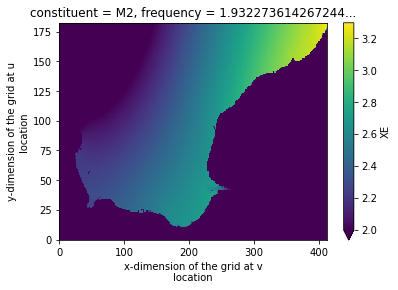

In [6]:
abs(h["XE"].sel(constituent="M2")).plot(vmin=2)

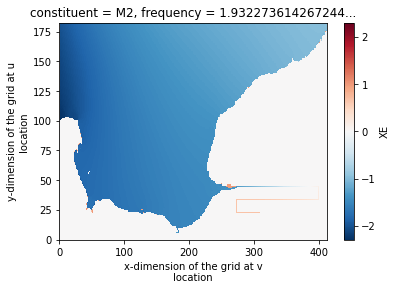

In [7]:
xr.apply_ufunc(np.angle, h["XE"].sel(constituent="M2").compute()).plot()

### Current ellipse properties

Current amplitudes are such that:

$
\begin{align}
u(t) &= \mathcal{R}\Big \{ U^\ast  e^{i\omega t}  \Big \}, \\
v(t) &= \mathcal{R}\Big \{ V^\ast  e^{i\omega t}  \Big \}, \\
u(t)+iv(t) &= \frac{U^\ast + i V^\ast}{2} e^{i\omega t} + \frac{U + i V}{2} e^{-i\omega t}  , \\
&= w_p e^{i\omega t} + w_n e^{-i\omega t}, \\
&= W_p e^{i(\omega t + \theta_p)} + W_n e^{i(-\omega t + \theta_n)}, \\
\end{align}
$

The **maximum current speed** is $A=W_p+W_n$ which occurs when:
$\omega t + \theta_p = -\omega t + \theta_n + 2n\pi$ 
or equivalently:
$\omega t = (-\theta_p + \theta_n)/2 + n\pi$.

The **phase** $\phi$ of maximum current speeds is thus:
$\phi=(-\theta_p + \theta_n)/2$.

The current ellipse **inclinaison** $\phi_i$ of the current is then:
$\phi_i=(\theta_p + \theta_n)/2$.

**Minimum current speed** $a$ is given by:
$a=W_p+W_n$.
It is positive for counter-clockwise rotation and negative for clockwise rotation.
The signed ellipticity is given by $a/A$.

In [149]:
def get_ellipse_properties(u, v):
    wp = (np.conj(u) + 1j*np.conj(v))/2
    wn = (u+1j*v)/2
    Wp, Wn = np.abs(wp), np.abs(wn)
    A = (Wp + Wn).rename("A")
    a = (Wp - Wn).rename("a")
    thetap = xr.apply_ufunc(np.angle, wp, dask="parallelized")
    thetan = xr.apply_ufunc(np.angle, wn, dask="parallelized")
    inclinaison = ((thetap+thetan)/2).rename("inclinaison")
    phase = ((-thetap+thetan)/2).rename("phase")
    return xr.merge([A, a, inclinaison, phase])

rad2deg = 180/np.pi

xgrid = ms.get_xgrid(h)

In [150]:
_u = xgrid.interp(h.U, "x")
_v = xgrid.interp(h.V, "y")
# normalize by sea level phase in order to be referenced with high tide
_ephi = h.XE/np.abs(h.XE)
_u = _u * np.conj(_ephi)
_v = _v * np.conj(_ephi)
e = get_ellipse_properties(_u, _v)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask/array/utils.py:107: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask/array/utils.py:107: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)


In [151]:
_e = e.sel(constituent="M2")

{'fig': <Figure size 720x360 with 2 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'constituent = M2, frequency = 1.932273614267244...'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x2aab708377f0>}

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0

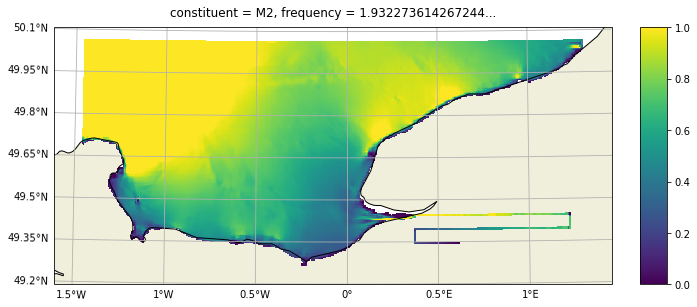

In [152]:
ms.plot_bs(_e["A"], vmax=1)

{'fig': <Figure size 720x360 with 2 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'constituent = M2, frequency = 1.932273614267244...'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x2aab714311f0>}

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0

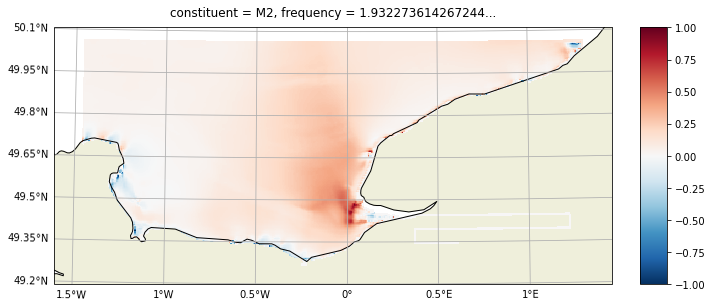

In [153]:
ms.plot_bs(_e["a"]/_e["A"], vmax=1)

{'fig': <Figure size 720x360 with 2 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'constituent = M2, frequency = 1.932273614267244...'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x2aab718ed7c0>}

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0

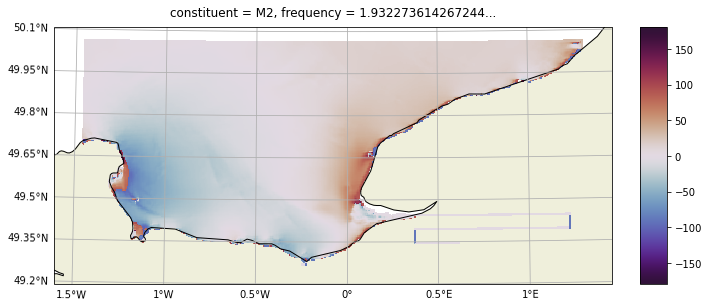

In [157]:
ms.plot_bs(_e["inclinaison"]*rad2deg, vmin=-180, vmax=180, cmap=cm.get_cmap("twilight_shifted"))

{'fig': <Figure size 720x360 with 2 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'constituent = M2, frequency = 1.932273614267244...'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x2aab72e26ca0>}

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0

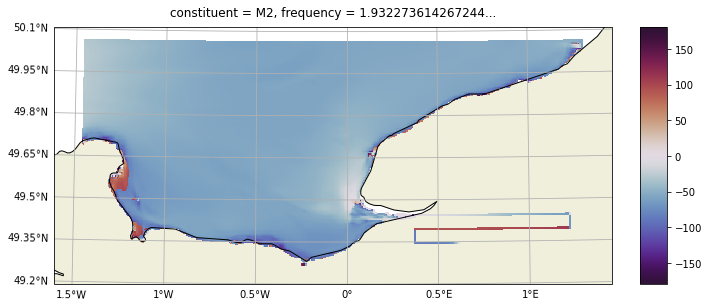

In [158]:
ms.plot_bs(_e["phase"]*rad2deg, vmin=-180, vmax=180, cmap=cm.get_cmap("twilight_shifted"))

### check at one location

In [159]:
# station position
lon=-.6
lat=49.7
idx = ms.get_horizontal_indices(h, lon=lon, lat=lat)

In [160]:
ds2D = xr.open_zarr(os.path.join(ms.diag_dir, "fields_2d.zarr"))
ds2D = ds2D.sel(**idx["rho"], ni_u=idx["u"]["ni_u"], nj_v=idx["v"]["nj_v"],
               time=slice("2014-04-01", "2014-04-30")).compute()

In [161]:
from matplotlib.patches import Ellipse

def plot_ellipse(ax, A, a, inclinaison, **kwargs):
    dkwargs = dict(edgecolor="k", facecolor="none", zorder=10, linewidth=2)
    dkwargs.update(**kwargs)
    ellipse = Ellipse((0, 0),
            width=float(A),
            height=float(a),
            angle=float(inclinaison)*180/np.pi,
                      **dkwargs,
            )
    ax.add_patch(ellipse)
    

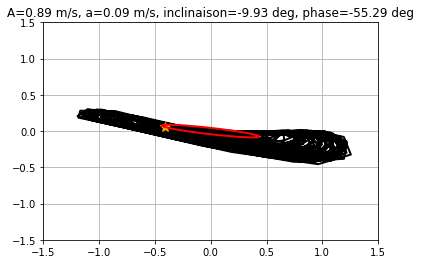

In [162]:
_ds = ds2D #.isel(time=slice(0,13))

fig, ax = plt.subplots(1,1)

ax.plot(_ds.U, _ds.V, color="k", lw=2)
ax.plot(_ds.U.isel(time=0), _ds.V.isel(time=0), "*", color="orange", markersize=10)

_e = e.sel(**idx["rho"], constituent="M2")
plot_ellipse(ax, _e.A, _e.a, _e.inclinaison, edgecolor="red")

ax.set_title("A={:.2f} m/s, a={:.2f} m/s, inclinaison={:.2f} deg, phase={:.2f} deg"\
             .format(float(_e.A), float(_e.a), 
                     float(_e.inclinaison*rad2deg), float(_e.phase*rad2deg))
            )
lims = (-1.5, 1.5)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.grid()

Text(0.5, 1.0, 'A=0.89 m/s, a=0.09 m/s, inclinaison=-9.93 deg, phase=-55.29 deg')

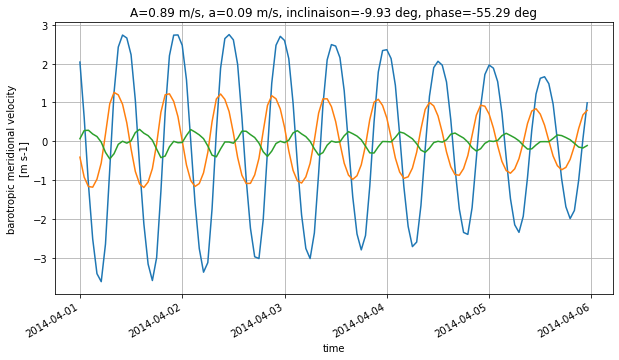

In [163]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

_ds = ds2D.isel(time=slice(0,24*5))

_ds.XE.plot(ax=ax)
_ds.U.plot(ax=ax)
_ds.V.plot(ax=ax)
ax.grid()

ax.set_title("A={:.2f} m/s, a={:.2f} m/s, inclinaison={:.2f} deg, phase={:.2f} deg"\
             .format(float(_e.A), float(_e.a), 
                     float(_e.inclinaison*rad2deg), float(_e.phase*rad2deg))
            )

In [164]:
u = _u.sel(**idx["rho"], constituent="M2").values
print(np.abs(u), np.angle(u)*rad2deg)
v = _v.sel(**idx["rho"], constituent="M2").values
print(np.abs(v), np.angle(v)*rad2deg)

0.8723383252763652 -54.311622900186755
0.17486796146551253 95.57155480742234


In [166]:
# phase in hours
float(_e.phase*rad2deg)*12/360

-1.8430328491055243

---

In [ ]:
cluster.close()